## Frekvenčná analýza

In [1]:
# dependencies
import pandas as pd
import os.path as path
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
import pickle
from sortedcontainers import SortedList
import time
import matplotlib.pyplot as plt

In [2]:
# local modules
import sys
sys.path.append("..")
from _ import constants

In [3]:
# load data
df_train = pd.read_csv(constants.TRAIN,sep=",")

In [4]:
len(df_train)

15932992

## Analýza atribútov

In [5]:
df_train.columns.unique()

Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
       'reference', 'platform', 'city', 'device', 'current_filters',
       'impressions', 'prices'],
      dtype='object')

Vypísaním stĺpcov atribútu sme identifikovali nasledovné stĺpce v datasete.

*   `user_id`: id používateľa
*   `session_id`: id relácie
*   `timestamp`: UNIX timestamp akcie
*   `step`: poradové číslo kroku v rámci session
*   `action_type`: typ akcie
    *   **clickout item**: používateľ sa preklikne a je presmerovaný na webstránku partnera. Referencia je v tomto prílade item_id. Ostatné položky, ktoré boli v tomto momente zobrazené a ich ceny sú v atribúte "impressions" a "prices"
    *   **interaction item rating**: používateľ interaguje s ratingom alebo reviewuje položku. Referencia je dané item_id.
    *   **interaction item info**: používateľ interaguje s informáciami o položke. Referencia je dané item_id.
    *   **interaction item image**: používateľ interaguje s obrázkom položky. Referencia je dané item_id.
    *   **interaction item deals**: používateľ klikne na "view more deals" tlačítko. Referencia je dané item_id.
    *   **change of sort order**: používateľ zmení poradie položiek. Referencia je popis atribútu zoradenia.
    *   **filter selection**: Používateľ použije filter. Referencia je popis filtra.
    *   **search for item**: používateľ vyhľadáva konkrétnu položku. Referencia je dané item_id.
    *   **search for destination**: používateľ hľadá destináciu. Referencia je desstinácia.
    *   **search for poi**: používateľ hľadá pre POI - point of interest. Referencia je názov POI.
*   `reference`: referencia, cieľ danej akcie
*   `platform`: krajina platformy, napr. [trivago.de](http://trivago.de) (DE) alebo [trivago.com](http://trivago.com) (US)
*   `city`: názov mesta kontextu vyhľadávania
*   `device`: zariadenie používateľa použité na vyhľadávanie
*   `current_filters`: zoznam filtrov ktoré boli aktívne
*   `impressions`: zoznam položiek, ktoré boli zobrazené používateľovi (prítomné iba pri action_type == clickout_item
*   `prices`: zoznam cien položiek, uvedené v atribúte "impressions" (prítomné iba pri action_type == clickout_item

### Atribút user_id

Ide o kategorický atribút vyjadrujúci unikátny identifikátor používateľa v databáze.

In [6]:
len(df_train.user_id)

15932992

In [7]:
len(df_train.user_id.unique())

730803

#### Počet záznamov user_id v datasete (počet akcií vykonaných daným používateľom)

Pozrieme sa na outlierov, chceme vidieť či tu nemáme nejakých používateľov príliš veľa alebo málo krát.

[Text(0.5, 1.0, 'Number of user occurences in dataset (actions)')]

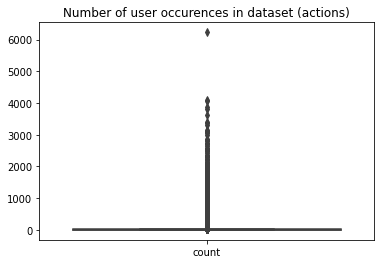

In [8]:
user_id_count = df_train.user_id.value_counts().reset_index(name="count").rename(columns={'index': 'user_id'})
sns.boxplot(data=user_id_count).set(title='Number of user occurences in dataset (actions)')

In [9]:
user_id_count.describe()

,count
count,730803.000000
mean,21.802034
std,64.406425
min,1.000000
25%,2.000000
50%,5.000000
75%,17.000000
max,6230.000000


/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/2490869866.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=user_id_groups['type'])


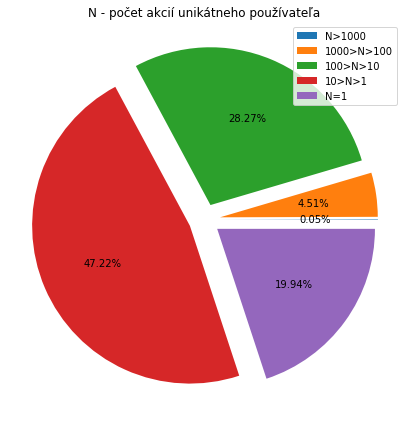

In [10]:
user_id_groups = pd.DataFrame({
    'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        user_id_count[user_id_count['count'] > 1000].count()[0],
        user_id_count[(user_id_count['count'] > 100) & (user_id_count['count'] < 1000)].count()[0],
        user_id_count[(user_id_count['count'] > 10) & (user_id_count['count'] < 100)].count()[0],
        user_id_count[(user_id_count['count'] > 1) & (user_id_count['count'] < 10)].count()[0],
        user_id_count[user_id_count['count'] == 1].count()[0]
    ]
});


pi,ax = plt.subplots(figsize=[10,6]);
plt.title("N - počet akcií unikátneho používateľa")
patches = plt.pie(x=user_id_groups['count'], explode=[0.1]*5, autopct="%.2f%%");
plt.legend(patches, labels=user_id_groups['type'])
plt.tight_layout();
plt.show();


Vidíme, že hodnoty sú distribuované dosť nízko, v jednotkách. Máme tu však aj outlierov, ktorí nám štatistiky ohýňajú. Väčšina používateľov však má len do 10 záznamov.

In [11]:
user_id_count[user_id_count['count'] > 1000]

,user_id,count
0,6JWWFFNUMY6Y,6230
1,0H73OEP6Z71O,4084
2,7K4V4W05S7X7,4077
3,SX3I42SKZEVH,3876
4,Q46K4RJHTQFR,3810
...,...,...
362,25NNYH9O26LO,1004
363,D365750VVN7G,1004
364,PV3Z6PE641TR,1003
365,O2QELYLYTK6W,1001


#### Detail najčastejšieho používateľa v datasete

Pozrieme sa na konkrétneho používateľa s maximálnym počtom interakcií.

In [12]:
u_id = user_id_count[user_id_count['count'] > 1000].iloc[0]['user_id'];
u_actions = df_train[df_train['user_id'] == u_id];
u_actions

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
8285800,6JWWFFNUMY6Y,87c17e7fea263,1541324109,1,search for destination,"Ankara, Turkey",TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285801,6JWWFFNUMY6Y,87c17e7fea263,1541324131,2,change of sort order,interaction sort button,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285802,6JWWFFNUMY6Y,87c17e7fea263,1541324164,3,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285803,6JWWFFNUMY6Y,87c17e7fea263,1541324164,4,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285804,6JWWFFNUMY6Y,87c17e7fea263,1541324164,5,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13455982,6JWWFFNUMY6Y,58a263c18b945,1541367642,2215,interaction item rating,36455,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
13455983,6JWWFFNUMY6Y,58a263c18b945,1541367642,2216,interaction item info,2432156,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
13455984,6JWWFFNUMY6Y,58a263c18b945,1541367643,2217,interaction item image,36455,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
13455985,6JWWFFNUMY6Y,58a263c18b945,1541367643,2218,interaction item image,36455,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN


#### Počet krokov v jednotlivých session

In [13]:
u_actions_grouped = u_actions.groupby('session_id',as_index=False)
u_actions_grouped['step'].last()

,session_id,step
0,3167404ed3197,3522
1,58a263c18b945,2219
2,7feceecc473c1,438
3,87c17e7fea263,51


Daný používateľ má v databáze dosť záznamov ale je to len zopár dlhých (v počte krokov) sessions. Niektoré z jeho akcií sú príliš blízko seba (timestamp) - v jednej sekunde dokázal robiť niekoľko akcií.
Domnievame sa, že môže ísť o bota. Túto teóriu by sme chceli potvrdiť alebo vyvrátiť tým, že sa pozrieme na priemerný čas danej session a daných interakcií.

#### Čas session a priemerný čas kroku

In [14]:
u_actions_grouped['timestamp']\
.agg(['first','last'])

,first,last
session_id,,
3167404ed3197,1541367709,1541368776
58a263c18b945,1541366414,1541367643
7feceecc473c1,1541361885,1541365480
87c17e7fea263,1541324109,1541324518


In [15]:
def min_max_diff(x):
    return x.max()-x.min()

def avg_step_duration(row):
    return row['session_length'] / row['steps']

def seconds_to_minutes(seconds):
    return round(seconds/60,2)

u_actions_per_session = u_actions_grouped\
.agg(
    steps=('step','last'),
    session_length=('timestamp',min_max_diff),
)

# calculate avergate duration of step
u_actions_per_session['avg_step_duration_seconds'] = u_actions_per_session.apply(avg_step_duration,axis=1);

# transform session length into minutes
u_actions_per_session['session_length'] = u_actions_per_session['session_length'].apply(seconds_to_minutes);

u_actions_per_session

,session_id,steps,session_length,avg_step_duration_seconds
0,3167404ed3197,3522,17.78,0.302953
1,58a263c18b945,2219,20.48,0.553853
2,7feceecc473c1,438,59.92,8.207763
3,87c17e7fea263,51,6.82,8.019608


#### Paralelné akcie

Dané session sú síce dlhé, ale priemerný čas pre jednu akciu vychádza pod sekundu - čo nie je reálne u používateľa - človeka.

Chceme sa teda pozrieť, o aké akcie ide.

In [16]:
u_actions_same_time = u_actions.groupby(['session_id','timestamp'],as_index=False).filter(lambda x: len(x['step'].unique()) > 1)
u_actions_same_time.head(5)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
8285802,6JWWFFNUMY6Y,87c17e7fea263,1541324164,3,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285803,6JWWFFNUMY6Y,87c17e7fea263,1541324164,4,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285804,6JWWFFNUMY6Y,87c17e7fea263,1541324164,5,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285805,6JWWFFNUMY6Y,87c17e7fea263,1541324164,6,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN
8285806,6JWWFFNUMY6Y,87c17e7fea263,1541324164,7,interaction item image,4572856,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN


In [17]:
u_actions_same_time_count = u_actions_same_time.groupby(['session_id','timestamp','action_type'])['timestamp'].count().reset_index(name="count")
u_actions_same_time_count

,session_id,timestamp,action_type,count
0,3167404ed3197,1541367709,interaction item image,14
1,3167404ed3197,1541367710,interaction item image,19
2,3167404ed3197,1541367710,interaction item rating,2
3,3167404ed3197,1541367712,interaction item image,31
4,3167404ed3197,1541367712,interaction item rating,1
...,...,...,...,...
506,7feceecc473c1,1541365480,interaction item image,4
507,87c17e7fea263,1541324164,interaction item image,12
508,87c17e7fea263,1541324174,interaction item image,9
509,87c17e7fea263,1541324184,interaction item image,13


Vidíme že ide o nasledovné akcie typu:

In [18]:
u_actions_same_time_count.action_type.unique()

array(['interaction item image', 'interaction item rating',
       'filter selection', 'change of sort order',
       'interaction item info', 'interaction item deals'], dtype=object)

### Atribút session

Opäť ide o kategorický atribút. Vyjadruje unikátny identifikátor session.

In [19]:
len(df_train.session_id.unique())

910683

Zaujímavou štatistikou je napríklad, koľko má ktorý používateľ sessions, a určiť outlierov.

In [20]:
u_session_count = df_train.groupby(['user_id'])['session_id'].nunique().reset_index(name='count')
u_session_count

,user_id,count
0,0001VQMGUI65,1
1,0003QTCX5MJX,1
2,0004IOZI7CKF,1
3,0004WCFRV3FB,1
4,0006W0R5A5V8,1
...,...,...
730798,ZZZPKIEICNT9,1
730799,ZZZPQ336U50Y,1
730800,ZZZRFN2DZ2BV,1
730801,ZZZRTATPZ6I4,1


In [21]:
u_session_count.describe()

,count
count,730803.000000
mean,1.246140
std,0.750184
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,201.000000


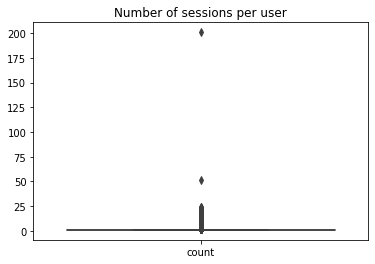

In [22]:
sns.boxplot(data=u_session_count).set(title="Number of sessions per user");

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/1737651595.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  patches = plt.legend(patches, labels=u_session_count_groups['type'])


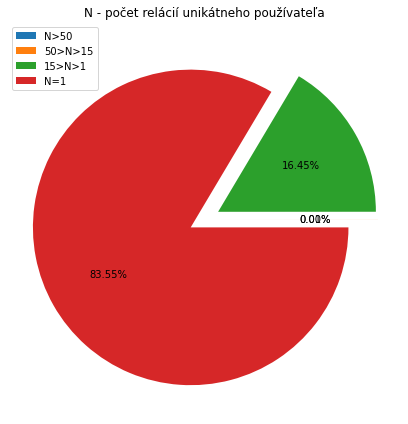

In [23]:
u_session_count_groups = pd.DataFrame({
    'type': [
        'N>50',
        '50>N>15',
        '15>N>1',
        'N=1'
    ],
    'count': [
        u_session_count[u_session_count['count'] > 50].count()[0],
        u_session_count[(u_session_count['count'] > 15) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[(u_session_count['count'] > 1) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[u_session_count['count'] == 1].count()[0],
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);

plt.pie(x=u_session_count_groups['count'], explode=[0.1]*4, autopct="%.2f%%");
patches = plt.legend(patches, labels=u_session_count_groups['type'])
plt.title('N - počet relácií unikátneho používateľa')
plt.tight_layout()
plt.show()

Z grafu vidíme, že väčšina používateľov má jednu session.

#### Počet akcií (krokov) v jednej session

Zaujímalo by nás, koľko akcií je v priemere v jednej session.

In [24]:
session_action_count = df_train.groupby(['session_id'])['action_type'].count().reset_index(name="count")

In [25]:
session_action_count.describe()

,count
count,910683.000000
mean,17.495651
std,48.181687
min,1.000000
25%,2.000000
50%,4.000000
75%,13.000000
max,3522.000000


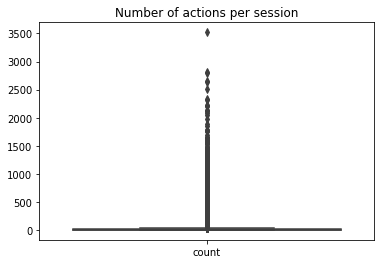

In [26]:
sns.boxplot(data=session_action_count).set(title="Number of actions per session");

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/3703885777.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=session_action_count_groups['type'])


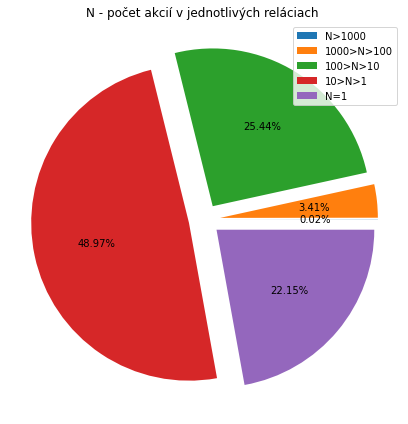

In [27]:
session_action_count_groups = pd.DataFrame({
   'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        session_action_count[session_action_count['count'] > 1000].count()[0],
        session_action_count[(session_action_count['count'] > 100) & (session_action_count['count'] < 1000)].count()[0],
        session_action_count[(session_action_count['count'] > 10) & (session_action_count['count'] < 100)].count()[0],
        session_action_count[(session_action_count['count'] > 1) & (session_action_count['count'] < 10)].count()[0],
        session_action_count[session_action_count['count'] == 1].count()[0]
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);

plt.pie(x=session_action_count_groups['count'], explode=[0.1]*5, autopct="%.2f%%");
plt.title('N - počet akcií v jednotlivých reláciach ')
plt.legend(patches, labels=session_action_count_groups['type'])
plt.tight_layout()
plt.show();

Vidíme, že tu su už dáta pomerne pekne distribuované. Na grafe môžme vidieť, že necelá polovica sessions má od 1-10 akcií. Vyše štvrtina je v rozpätií 10-100. Necelá štvrtina sú single-step sessions. 

#### Dĺžka sessions

In [28]:
sessions_grouped = df_train.groupby(['session_id'])
sessions_grouped['timestamp'].agg(['first','last'])

,first,last
session_id,,
00000510f1adc,1541064087,1541064087
00003f3b20954,1541097696,1541097696
000056cd97ce2,1541483846,1541484101
000066611146f,1541332305,1541332330
00008c1f39c46,1541302205,1541302405
...,...,...
tpc71ussgcuou,1541523289,1541523289
u5e4la6f115r1,1541529473,1541529473
udmhn71cn8500,1541245078,1541245315


In [29]:
session_steps_length = sessions_grouped\
.agg(
    steps=('step','last'),
    session_length=('timestamp',min_max_diff),
)

In [30]:
# calculate avergate duration of step
session_steps_length['avg_step_duration_seconds'] = session_steps_length.apply(avg_step_duration,axis=1);

# transform session length into minutes
session_steps_length['session_length'] = session_steps_length['session_length'].apply(seconds_to_minutes);

session_steps_length

,steps,session_length,avg_step_duration_seconds
session_id,,,
00000510f1adc,1,0.00,0.000000
00003f3b20954,1,0.00,0.000000
000056cd97ce2,4,4.25,63.750000
000066611146f,3,0.42,8.333333
00008c1f39c46,4,3.33,50.000000
...,...,...,...
tpc71ussgcuou,1,0.00,0.000000
u5e4la6f115r1,1,0.00,0.000000
udmhn71cn8500,11,3.95,21.545455


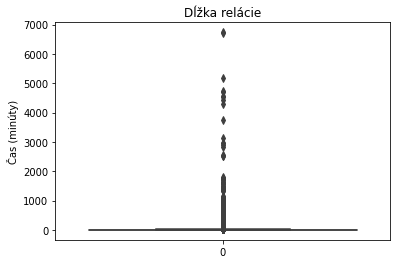

In [31]:
ax = sns.boxplot(data=session_steps_length.session_length).set(title="Dĺžka relácie",ylabel="Čas (minúty)");

#### Najdlhšie sessions (v minútach)

In [32]:
session_steps_length.sort_values(by="session_length",ascending=False).head(10)

,steps,session_length,avg_step_duration_seconds
session_id,,,
907cb2db5cec5,2,6740.05,202201.500000
2a181b2125efe,1,6712.15,402729.000000
c0c2730fdde6c,44,5184.05,7069.159091
7a37b2c63a02f,26,4732.80,10921.846154
4cd200e050285,2,4701.35,141040.500000
a0163701c3369,40,4549.37,6824.050000
8c41f0b873b0b,77,4515.92,3518.896104
1892588e0a4fc,195,4422.42,1360.743590
14ffe9351be7c,1,4291.45,257487.000000


In [33]:
df_train[df_train.session_id == '907cb2db5cec5']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1195332,2DQ7VEGMWKMC,907cb2db5cec5,1541100192,1,clickout item,14893,DE,"Cologne, Germany",mobile,NaN,14893|6477|13714|6446|6435|6468|14944|51543|52...,136|134|169|167|178|81|139|89|84|84|187|110|84...
15841494,2DQ7VEGMWKMC,907cb2db5cec5,1541504562,1,clickout item,51051,DE,"Oberstaufen, Germany",mobile,NaN,141398|51612|51272|137554|3478570|51051|121851...,180|172|160|122|120|120|229|274|135|129|89|97|...
15841495,2DQ7VEGMWKMC,907cb2db5cec5,1541504595,2,clickout item,51272,DE,"Oberstaufen, Germany",mobile,NaN,141398|51612|51272|137554|3478570|51051|121851...,180|172|160|122|120|120|229|274|135|129|89|97|...


In [34]:
df_train[df_train.session_id == '2a181b2125efe']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
5054814,7X4FZTVRCDQA,2a181b2125efe,1541329853,1,search for destination,"Rimini, Italy",IT,"Rimini, Italy",mobile,NaN,NaN,NaN
6267791,7X4FZTVRCDQA,2a181b2125efe,1541506315,1,search for destination,"Milan, Italy",IT,"Milan, Italy",mobile,NaN,NaN,NaN
8324291,7X4FZTVRCDQA,2a181b2125efe,1541103586,1,clickout item,94907,IT,"Giardini-Naxos, Italy",mobile,NaN,94907|101278|82654|23607|23610|45848|1203406|2...,82|55|87|187|85|98|184|94|86|111|144|87|223|49...


Ako vidíme, tu sme asi našli chybu v dátach. Tým že sme brali first a last z danej session, dĺžka session sa nám natiahla do enormných rozmerov. Bolo by preto vhodné deduplikovať záznamy user - session nad atribútom step (najvhodnejšie by bolo asi nechať last)

### Atribút action_type

In [35]:
df_train.action_type.unique()

array(['search for poi', 'interaction item image', 'clickout item',
       'interaction item info', 'interaction item deals',
       'search for destination', 'filter selection',
       'interaction item rating', 'search for item',
       'change of sort order'], dtype=object)

In [36]:
actions_count = df_train['action_type'].value_counts().reset_index(name="count").rename(columns={'index':'action_type'})
actions_count

,action_type,count
0,interaction item image,11860750
1,clickout item,1586586
2,filter selection,695917
3,search for destination,403066
4,change of sort order,400584
5,interaction item info,285402
6,interaction item rating,217246
7,interaction item deals,193794
8,search for item,152203
9,search for poi,137444


/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/67991065.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=actions_count['action_type'])


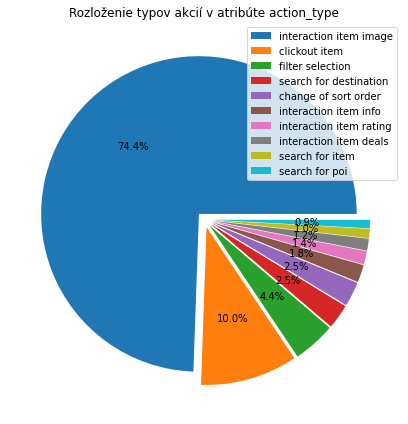

In [37]:
pi,ax = plt.subplots(figsize=[10,6]);

patches = plt.pie(x=actions_count['count'], explode=[0.05]*10, autopct="%.1f%%")
plt.title('Rozloženie typov akcií v atribúte action_type')
plt.legend(patches, labels=actions_count['action_type'])
plt.tight_layout()
plt.show()

#### Aké stepy sú pred interaction with item image?

In [38]:
tmp = df_train.reset_index()
first_interaction_item_image = tmp[tmp['action_type'] == 'interaction item image'].groupby(['user_id','session_id','action_type']).first()

In [39]:
# filter out those iteractions, which are step 1
first_interaction_item_image = first_interaction_item_image[first_interaction_item_image['step'] != 1]

# get previous rows (x-1)
interaction_image_prec_rows = df_train.loc[df_train.index.isin(list(map(lambda x: x-1, first_interaction_item_image['index'].tolist())))]

In [40]:
interaction_image_prec_rows.action_type.unique()

array(['search for poi', 'interaction item info', 'filter selection',
       'clickout item', 'search for destination',
       'interaction item rating', 'interaction item deals',
       'search for item', 'change of sort order'], dtype=object)

#### Aké stepy sú pred clickoutom?

In [41]:
first_clickout = tmp[tmp['action_type'] == 'clickout item'].groupby(['user_id','session_id','action_type']).first()

# filter out those iteractions, which are step 1
first_clickout = first_clickout[first_clickout['step'] != 1]

# get previous rows (x-1)
clickout_prec_rows = df_train.loc[df_train.index.isin(list(map(lambda x: x-1, first_clickout['index'].tolist())))]

In [42]:
clickout_prec_rows.action_type.unique()

array(['interaction item image', 'interaction item info',
       'search for item', 'filter selection', 'interaction item rating',
       'search for poi', 'search for destination',
       'interaction item deals', 'change of sort order'], dtype=object)

### Atribút impressions a prices

Kedy su dané atribúty prítomné?

In [43]:
not_na_impressions = df_train[df_train['impressions'].notna()]

In [44]:
not_na_prices = df_train[df_train['prices'].notna()]

Ide o ten istý dataset?

In [45]:
not_na_impressions.equals(not_na_prices)

True

#### Kedy je prítomný, v akej akcií?

In [46]:
not_na_impressions.action_type.unique()

array(['clickout item'], dtype=object)

#### Koľko máme impresií? Je počet stále rovnaký? Je počet rovnaký s prices?

In [47]:
not_na_impressions['impressions'] = not_na_impressions.impressions.apply(lambda x: len(x.split('|')))

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/3002420512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_na_impressions['impressions'] = not_na_impressions.impressions.apply(lambda x: len(x.split('|')))


In [48]:
not_na_impressions['prices'] = not_na_impressions.prices.apply(lambda x: len(x.split('|')))

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_81663/4067869892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_na_impressions['prices'] = not_na_impressions.prices.apply(lambda x: len(x.split('|')))


In [49]:
not_na_impressions.impressions.unique()
not_na_impressions.prices.unique()

array([25,  4, 12, 16,  7, 10, 24,  8, 18, 20,  2, 21, 13,  9, 19, 14,  5,
       22, 23, 11, 15, 17,  3,  1,  6])

Vidíme teda, že počet nie je rovnaký stále.

In [50]:
not_na_impressions.apply(lambda row: row['impressions'] == row['prices'],axis = 1).unique()

array([ True])

Ale počet cien sa zhoduje s počtom impresií, a podľa zadania idú v poradí, takže tu nemáme špinavé dáta.